Chapter 8 Exercises

In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.datasets import get_rdataset
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS



from sklearn.tree import (DecisionTreeClassifier as DTC, DecisionTreeRegressor as DTR, plot_tree, export_text)
from sklearn.metrics import (accuracy_score, log_loss)
from sklearn.ensemble import (RandomForestRegressor as RF, GradientBoostingRegressor as GBR)
from ISLP.bart import BART

print('Done')

Done


7

In [2]:
Boston = load_data('Boston')
Boston

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,6.48,22.0


In [3]:
model = MS(Boston.columns.drop('medv'), intercept=False)
D = model.fit_transform(Boston)
feature_names = list(D.columns)
X = np.asarray(D)

In [4]:
(X_train, X_test, y_train, y_test) = skm.train_test_split(X, Boston['medv'], test_size=0.3, random_state=0)

In [5]:
bag_boston = RF(max_features=X_train.shape[1], random_state=0)
bag_boston.fit(X_train, y_train)



RandomForestRegressor(max_features=12, random_state=0)

In [6]:
RF_boston = RF(max_features=6, random_state=0).fit(X_train, y_train)
y_hat_RF = RF_boston.predict(X_test)

In [7]:
np.mean((y_test - y_hat_RF)**2)

20.04276446710527

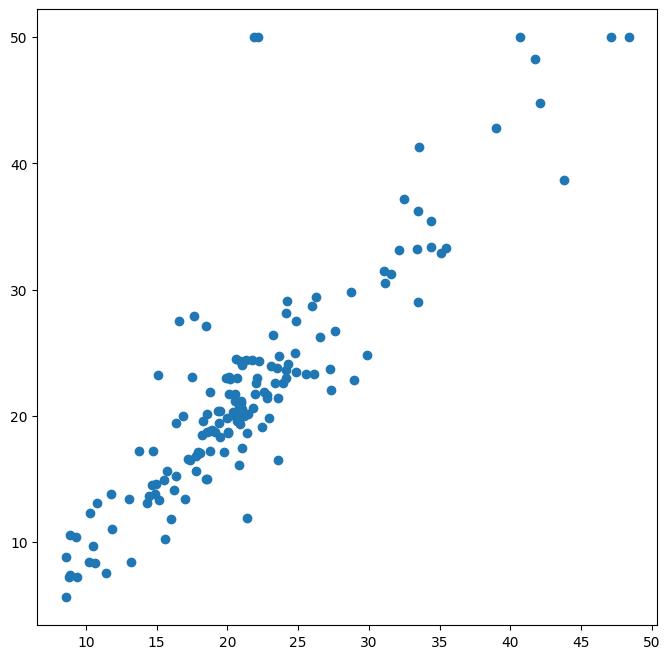

In [8]:
ax = subplots(figsize=(8,8))[1]
ax.scatter(y_hat_RF,y_test);

A

In [9]:
errors = np.array([])

for i in range(1,12):
    RF_boston = RF(max_features=int(i), random_state=0, n_estimators=1000).fit(X_train, y_train)
    y_hat_RF = RF_boston.predict(X_test)
    temp_mse = np.mean((y_test - y_hat_RF)**2)
    errors = np.append(errors, temp_mse)



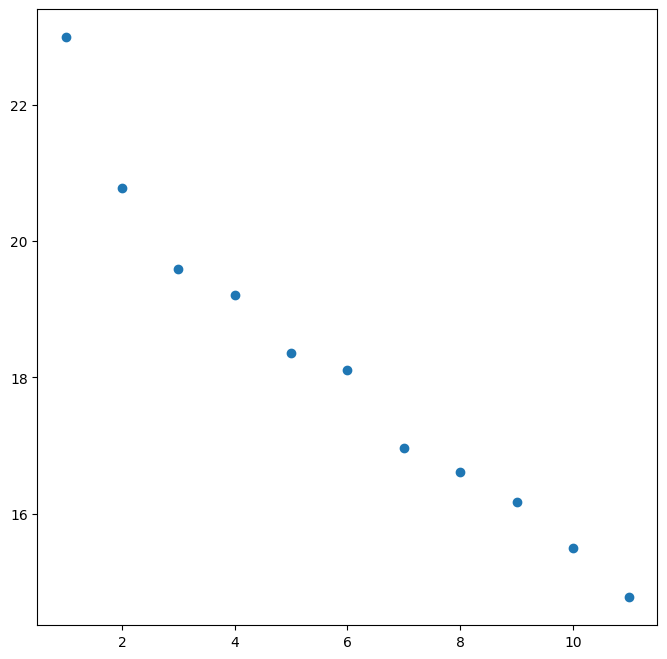

In [10]:
feature_length = np.arange(1,12)

ax = subplots(figsize=(8,8))[1]
ax.scatter(feature_length, errors);

This is very clear evidence that the more we lean towards a full bagged model, the test MSE goes down and the model performs better. This is very likely because the advantage of random forests in reducing variance does little for the boston dataset, which only has p = 13 for n = 506

8

In [11]:
Carseats = load_data('Carseats')
Carseats

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...
395,12.57,138,108,17,203,128,Good,33,14,Yes,Yes
396,6.14,139,23,3,37,120,Medium,55,11,No,Yes
397,7.41,162,26,12,368,159,Medium,40,18,Yes,Yes
398,5.94,100,79,7,284,95,Bad,50,12,Yes,Yes


In [12]:
Y = Carseats['Sales']

model = MS(Carseats.columns.drop('Sales'), intercept=False)
D = model.fit_transform(Carseats)
feature_names = list(D.columns)
X = np.asarray(D)

A

In [13]:
(X_train, X_test, y_train, y_test) = skm.train_test_split(X, Carseats['Sales'], test_size=0.3, random_state=0)

B

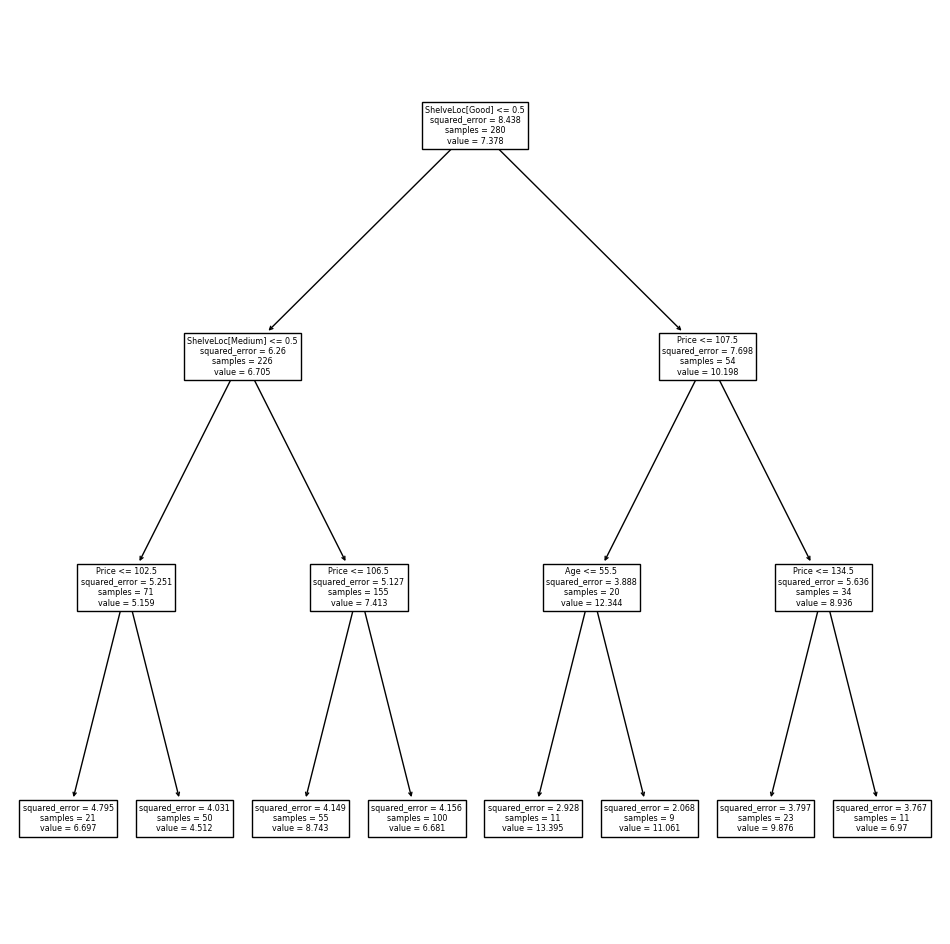

In [14]:
reg = DTR(max_depth=3)
reg.fit(X_train, y_train)
ax = subplots(figsize=(12,12))[1]
plot_tree(reg, feature_names=feature_names, ax=ax);

In [15]:
np.mean((y_test - reg.predict(X_test))**2)

3.7038582752360942

C

In [16]:
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5, shuffle=True, random_state=10)
grid = skm.GridSearchCV(reg, {'ccp_alpha': ccp_path.ccp_alphas}, refit=True, cv=kfold, scoring='neg_mean_squared_error')
G = grid.fit(X_train, y_train)

best_ = grid.best_estimator_
np.mean((y_test - best_.predict(X_test))**2)

3.7038582752360942

We obtain a test MSE of 3.7 after crossvalidation of the various trees. Pruning did not improve upon the original tree

D

In [17]:
bag_Carseats = RF(max_features=X_train.shape[1], random_state=0)
bag_Carseats.fit(X_train, y_train)
y_hat_bag = bag_Carseats.predict(X_test)
np.mean((y_test - y_hat_bag)**2)

2.0077445197500015

In [18]:
feature_imp = pd.DataFrame( {'importance':bag_Carseats.feature_importances_}, index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
Price,0.278666
ShelveLoc[Good],0.222431
Age,0.108637
CompPrice,0.097085
ShelveLoc[Medium],0.082965
Advertising,0.074627
Income,0.051799
Population,0.040945
Education,0.030836
US[Yes],0.006815


E

In [19]:
errors = np.array([])

for i in range(1,10):
    RF_Carseats = RF(max_features=int(i), random_state=0, n_estimators=1000).fit(X_train, y_train)
    y_hat_RF = RF_Carseats.predict(X_test)
    temp_mse = np.mean((y_test - y_hat_RF)**2)
    errors = np.append(errors, temp_mse)

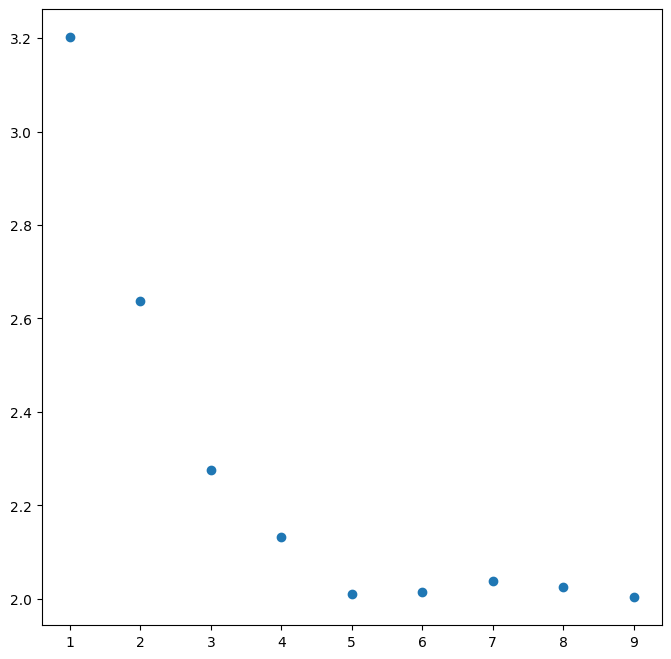

In [20]:
feature_length = np.arange(1,10)

ax = subplots(figsize=(8,8))[1]
ax.scatter(feature_length, errors);

In [21]:
RF_Carseats = RF(max_features=5, random_state=0, n_estimators=1000).fit(X_train, y_train)
y_hat_RF = RF_Carseats.predict(X_test)
np.mean((y_test - y_hat_RF)**2)

2.0094367383033207

In [22]:
feature_imp = pd.DataFrame( {'importance':RF_Carseats.feature_importances_}, index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
Price,0.268335
ShelveLoc[Good],0.183921
Age,0.117260
CompPrice,0.100485
Advertising,0.082242
Income,0.070504
ShelveLoc[Medium],0.060387
Population,0.057371
Education,0.039804
US[Yes],0.011500


The bagged and Random forests model with m = 5 outperformed the regular model by both having a test MSE of approx. 2 versus 3.7 for the original tree. The random forest exhibited its best performance at m >=5, so naturally we went with the simplest model.

9

In [23]:
OJ = load_data('OJ')
OJ

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,CH,237,1,1.75,1.99,0.00,0.00,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
1,CH,239,1,1.75,1.99,0.00,0.30,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
2,CH,245,1,1.86,2.09,0.17,0.00,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
3,MM,227,1,1.69,1.69,0.00,0.00,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
4,CH,228,7,1.69,1.69,0.00,0.00,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065,CH,252,7,1.86,2.09,0.10,0.00,0,0,0.587822,2.09,1.76,0.33,Yes,0.000000,0.053763,0.23,0
1066,CH,256,7,1.86,2.18,0.00,0.00,0,0,0.670258,2.18,1.86,0.32,Yes,0.000000,0.000000,0.32,0
1067,MM,257,7,1.86,2.18,0.00,0.00,0,0,0.736206,2.18,1.86,0.32,Yes,0.000000,0.000000,0.32,0
1068,CH,261,7,1.86,2.13,0.00,0.24,0,0,0.588965,1.89,1.86,0.03,Yes,0.112676,0.000000,0.27,0


In [50]:
OJ = pd.get_dummies(OJ, columns=['Store7'])

In [51]:
OJ

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,PctDiscMM,PctDiscCH,ListPriceDiff,STORE,Store7_No,Store7_Yes
0,CH,237,1,1.75,1.99,0.00,0.00,0,0,0.500000,1.99,1.75,0.24,0.000000,0.000000,0.24,1,True,False
1,CH,239,1,1.75,1.99,0.00,0.30,0,1,0.600000,1.69,1.75,-0.06,0.150754,0.000000,0.24,1,True,False
2,CH,245,1,1.86,2.09,0.17,0.00,0,0,0.680000,2.09,1.69,0.40,0.000000,0.091398,0.23,1,True,False
3,MM,227,1,1.69,1.69,0.00,0.00,0,0,0.400000,1.69,1.69,0.00,0.000000,0.000000,0.00,1,True,False
4,CH,228,7,1.69,1.69,0.00,0.00,0,0,0.956535,1.69,1.69,0.00,0.000000,0.000000,0.00,0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065,CH,252,7,1.86,2.09,0.10,0.00,0,0,0.587822,2.09,1.76,0.33,0.000000,0.053763,0.23,0,False,True
1066,CH,256,7,1.86,2.18,0.00,0.00,0,0,0.670258,2.18,1.86,0.32,0.000000,0.000000,0.32,0,False,True
1067,MM,257,7,1.86,2.18,0.00,0.00,0,0,0.736206,2.18,1.86,0.32,0.000000,0.000000,0.32,0,False,True
1068,CH,261,7,1.86,2.13,0.00,0.24,0,0,0.588965,1.89,1.86,0.03,0.112676,0.000000,0.27,0,False,True


A-C

In [52]:
Response = np.where(OJ.Purchase == 'MM', 'Yes', 'No')


model = MS(OJ.columns.drop('Purchase'), intercept=False)
D = model.fit_transform(OJ)
feature_names = list(D.columns)
X = np.asarray(D)

In [53]:
(X_train, X_test, Response_train, Response_test) = skm.train_test_split(X, Response, test_size= 270, random_state=0)

In [54]:
clf = DTC(criterion='entropy', random_state=0)
clf.fit(X_train, Response_train)
accuracy_score(Response_test, clf.predict(X_test))

0.7703703703703704

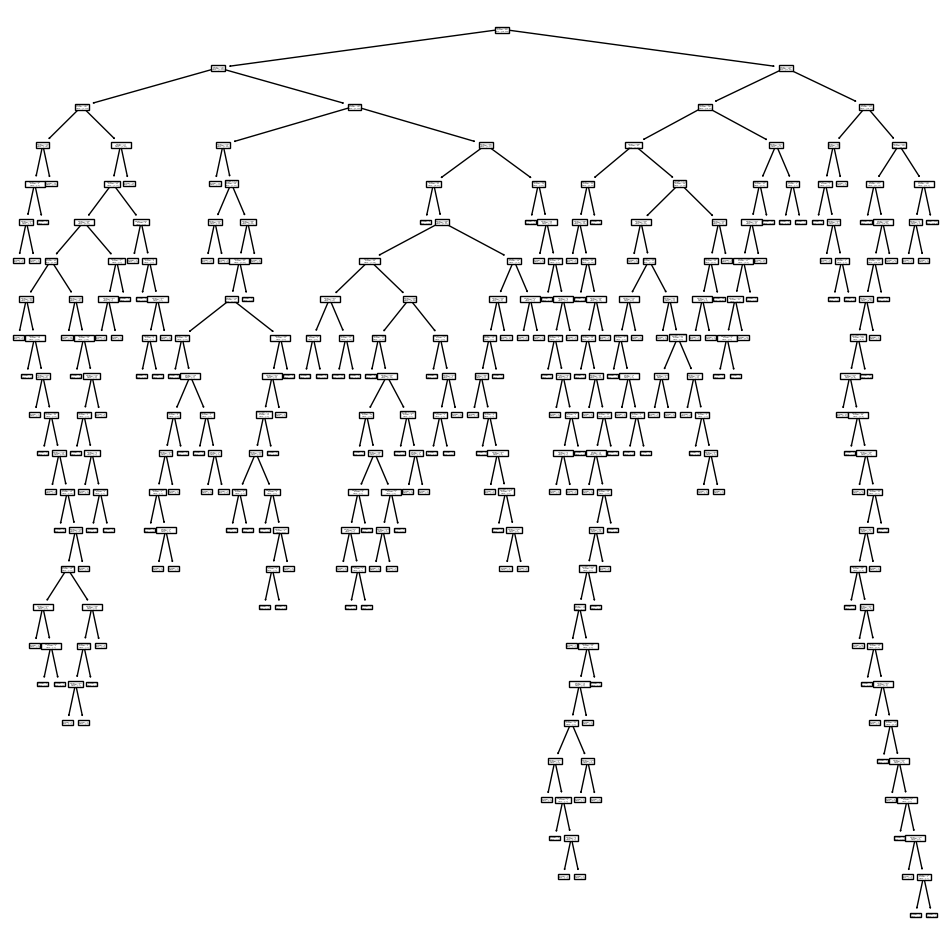

In [55]:
ax = subplots(figsize=(12, 12))[1]
plot_tree(clf, feature_names=feature_names, ax=ax);

In [61]:
clf.get_n_leaves()

170

There are by the end, 170 terminal nodes in this decision tree, making the results quite uninterpretable.

E

In [64]:
confusion = confusion_table(clf.predict(X_test), Response_test)
confusion

Truth,No,Yes
Predicted,,
No,123,32
Yes,30,85


In [65]:
print(accuracy_score(Response_test, clf.predict(X_test)))

0.7703703703703704


The test error rate is about 23%

F,H

In [80]:
ccp_path = clf.cost_complexity_pruning_path(X_train, Response_train)
kfold = skm.KFold(10, random_state=1, shuffle=True)

grid = skm.GridSearchCV(clf, {'ccp_alpha': ccp_path.ccp_alphas}, refit=True, cv=kfold, scoring='accuracy')
grid.fit(X_train, Response_train)
grid.best_score_

0.805

In [81]:
best_ = grid.best_estimator_

In [82]:
best_.tree_.n_leaves

7

The optimal tree size selected by 5-fold cross validation is one with 7 leaves.

G

In [84]:
testerror = np.array([])

for i in range(1,20):
    clf = DTC( max_depth= i, criterion='entropy', random_state= 0)
    clf.fit(X_train, Response_train)
    temp_error = 1 - accuracy_score(Response_test, clf.predict(X_test))
    testerror = np.append(testerror, temp_error)


num_leaves = np.arange(1,20)


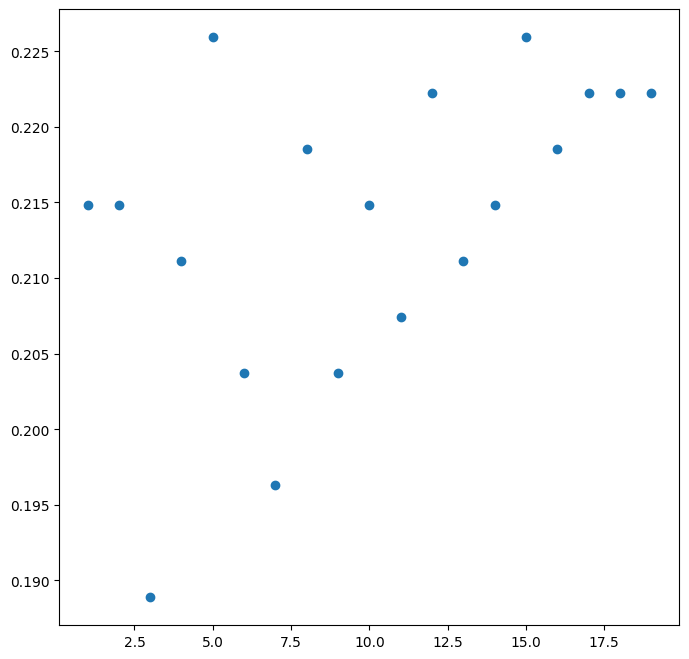

In [85]:
ax = subplots(figsize=(8,8))[1]
ax.scatter(num_leaves, testerror);

H

While a tree with 3 leaves performed best on the test set with 7 being second best, both the test set and the cross-validation results point to 7 being the optimal value

I

In [86]:
clf = DTC(criterion='entropy', max_depth=7, random_state= 0)
clf.fit(X_train, Response_train)
accuracy_score(Response_test, clf.predict(X_test))

0.8037037037037037

The original, unpruned tree had a 3% higher test error rate.